# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded import VLE_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# MPCC construction
model.beta = pe.Var(within=pe.NonNegativeReals,initialize=1)
model.s_L= pe.Var(within=pe.NonNegativeReals,initialize=0,bounds=(0,1))
model.s_V= pe.Var(within=pe.NonNegativeReals,initialize=0)

# MPCC Parameters

In [5]:
model.epi = pe.Param(initialize=1e-4,mutable=True)
model.rho = pe.Param(initialize=10,mutable=True)

# Construct Individual Blocks

In [6]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [7]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [8]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [9]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [10]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.beta*model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: Beta

In [11]:
def beta_rule(model):
    return model.beta == 1-model.s_L + model.s_V
model.beta_con = pe.Constraint(rule=beta_rule)

# def s_L_complementarity_rule(model):
#     return (sum(model.L[s] for s in model.outlet) + model.s_L) == ((sum(model.L[s] for s in model.outlet) - model.s_L)**2+model.epi)**0.5
#     # return sum(model.L[s] for s in model.outlet) * model.s_L <= model.epi
# model.s_L_complementarity_con = pe.Constraint(rule=s_L_complementarity_rule)

# def s_V_complementarity_rule(model):
#     return (sum(model.V[s] for s in model.outlet) + model.s_V) == ((sum(model.V[s] for s in model.outlet) - model.s_V)**2+model.epi)**0.5
#     # return sum(model.V[s] for s in model.outlet) * model.s_V <= model.epi
# model.s_V_complementarity_con = pe.Constraint(rule=s_V_complementarity_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [12]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [13]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [14]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [15]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [16]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [17]:
check_DOF(pe,model)

Active Equality Constraints:	 1182
Active Inequality Constraints:	 0
Active Variables:		 1357
Fixed Variables:		 172
DOF:				 3


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [18]:
model.T.setub(300+273.15)

In [19]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
# model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T - model.rho*\
            (sum(model.L[s] for s in model.outlet)*model.s_L + sum(model.V[s] for s in model.outlet)*model.s_V) ,sense=pe.maximize)

In [20]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
# opt.options['linear_solver'] = 'ma86'
# opt.options['ma57_automatic_scaling'] = 'no'
# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4012
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.1302894e+02 2.74e+00 1.02e+07  -1.0 5.21e+02    -  1.79e-01 6.68e-01w  1
  81 -5.1819213e+02 4.23e+00 7.92e+06  -1.0 5.12e+02    -  4.15e-01 9.56e-01w  1
  82 -5.0926668e+02 2.69e-01 2.06e+06  -1.0 5.09e+02    -  1.00e+00 1.04e-01h  3
  83 -5.0936418e+02 2.69e-01 1.99e+06  -1.0 3.82e+02    -  1.00e+00 1.03e-01h  4
  84 -5.0947578e+02 2.69e-01 1.96e+06  -1.0 3.80e+02    -  1.00e+00 1.04e-01h  4
  85 -5.0959018e+02 2.67e-01 2.10e+06  -1.0 3.69e+02    -  1.00e+00 1.05e-01h  4
  86 -5.0972566e+02 2.66e-01 2.26e+06  -1.0 3.70e+02    -  1.00e+00 1.06e-01h  4
  87 -5.0986945e+02 2.64e-01 2.41e+06  -1.0 3.63e+02    -  1.00e+00 1.06e-01h  4
  88 -5.1002542e+02 2.62e-01 2.57e+06  -1.0 3.62e+02    -  1.00e+00 1.06e-01h  4
  89 -5.1019253e+02 2.59e-01 2.71e+06  -1.0 3.53e+02    -  1.00e+00 1.08e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.1037796e+02 2.57e-01

 172 -5.5737397e+02 1.50e-10 3.94e+12  -3.8 2.48e-07  17.4 1.00e+00 1.00e+00h  1
 173 -5.5737397e+02 4.62e-07 3.94e+12  -5.7 8.12e-02    -  1.28e-03 8.96e-05h  4
 174r-5.5737397e+02 4.62e-07 1.00e+03  -5.7 0.00e+00    -  0.00e+00 3.22e-07R 10
 175r-5.5737392e+02 1.16e-07 8.51e+02  -5.7 2.24e+00    -  1.81e-01 3.96e-03f  1
 176r-5.5737161e+02 2.52e-06 2.77e+02  -5.7 2.37e+00    -  8.07e-01 1.87e-01f  1
 177r-5.5736304e+02 3.49e-05 9.72e+02  -5.7 2.12e+00    -  1.01e-01 7.71e-01h  1
 178r-5.5735935e+02 6.36e-06 2.23e+01  -5.7 7.04e-01    -  8.86e-01 1.00e+00h  1
 179r-5.5736026e+02 3.53e-05 8.04e+01  -5.7 3.23e-01    -  7.81e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r-5.5736022e+02 1.17e-05 3.33e+02  -5.7 1.35e-01    -  3.75e-01 1.00e+00h  1
 181r-5.5735933e+02 7.83e-06 1.58e+02  -5.7 1.10e-01    -  6.41e-01 1.00e+00h  1
 182r-5.5735889e+02 2.87e-05 1.57e+02  -5.7 3.57e-01    -  5.83e-01 1.00e+00h  1
 183r-5.5735468e+02 5.53e-05

 273 -5.7055053e+02 5.51e-01 8.99e+08  -5.7 1.89e-01  11.7 3.16e-09 5.39e-03f  5
 274 -5.7055053e+02 5.50e-01 2.06e+11  -5.7 5.03e-06  16.6 9.65e-01 1.00e+00h  1
 275 -5.7055045e+02 5.35e-01 2.22e+14  -5.7 1.88e-01  16.1 5.40e-03 2.67e-02h  1
 276r-5.7055045e+02 5.35e-01 1.00e+03  -0.4 0.00e+00  19.3 0.00e+00 0.00e+00R  1
 277r-5.7052723e+02 5.35e-01 1.00e+03  -0.4 2.69e+05    -  8.50e-07 7.68e-07f  1
 278r-5.7052861e+02 5.27e-01 1.01e+03  -0.4 6.68e+03    -  3.30e-04 1.48e-05f  1
 279r-5.7052944e+02 1.96e-01 3.93e+03  -0.4 1.39e+03    -  8.48e-05 8.36e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -5.7058993e+02 1.98e-01 2.34e+02  -5.7 6.59e+05    -  1.37e-03 1.86e-05f  1
 281 -5.7061041e+02 1.89e-01 1.36e+04  -5.7 1.67e+02    -  5.57e-03 4.77e-02f  1
 282 -5.7061041e+02 1.89e-01 7.08e+10  -5.7 4.28e-09  19.2 1.00e+00 1.00e+00h  1
 283 -5.7061047e+02 1.89e-01 7.07e+10  -5.7 7.30e-01    -  5.80e-02 4.83e-04h  1
 284 -5.7061047e+02 1.89e-01

In [21]:
model.T.value

573.15

In [22]:
model.beta.value

0.12015591900434268

In [23]:
model.s_L.value

0.8798440711942378

In [24]:
model.L['out'].value

0.0

In [25]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 0.4578
------------------------------------------------------------------------------------------------------------
H2         		 0.1371%			 0.3424%
CO         		 0.1236%			 0.2654%
CO2        		46.5965%			56.2353%
H2O        		10.9282%			 8.6187%
C2H4       		 5.6470%			 5.5917%
C3H6       		 5.8141%			 3.2153%
C4H8       		 2.3491%			 1.4282%
C5H10      		 1.6894%			 0.5529%
C6H12      		 1.3174%			 0.2585%
C7H14      		 0.9597%			 0.1208%
C8H16      		 0.6670%			 0.0565%
C9H18      		 0.4480%			 0.0264%
C10H20     		 0.2932%			 0.0123%
C11H22     		 0.1198%			 0.0037%
C12H24     		 0.0756%			 0.0017%
C13H26     		 0.0470%			 0.0008%
C14H28     		 0.0289%			 0.0004%
C15H30     		 0.0177%			 0.0002%
C16H32     		 0.0107%			 0.0001%
C17H34     		 0.0064%			 0.0000%
C18H36     		 0.0038%			 0.0000%
C19H38     		 0.0023%			 0.0000%
C20H40     		 0.0013%			 0.0000%
C1H4       		13.3744%			18.3934%
C2H6       		 3.2294%			 3.0063%
C3H8       		 1.3664%			

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [28]:
catrange = [3000,1000,500,300,100,50,10]
Trange = np.linspace(300+273.15,200+273.15,31)

In [29]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat + model.rho*\
                (sum(model.L[s] for s in model.outlet)*model.s_L + sum(model.V[s] for s in model.outlet)*model.s_V) ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    model.rho = 1
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T - model.rho*\
            (sum(model.L[s] for s in model.outlet)*model.s_L + sum(model.V[s] for s in model.outlet)*model.s_V) ,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    model.rho = 1
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['beta'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|s_L = {:.4f}\t|beta = {:.4f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.s_L.value,model.beta.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['beta'].append(model.beta.value)
        rf_data['s_L'].append(model.s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4578 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8798	|beta = 0.1202
Solved	|T = 569.82 K	|V = 0.4555 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8765	|beta = 0.1235
Solved	|T = 566.48 K	|V = 0.4530 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8727	|beta = 0.1273
Solved	|T = 563.15 K	|V = 0.4504 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8681	|beta = 0.1319
Solved	|T = 559.82 K	|V = 0.4477 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8626	|beta = 0.1374
Solved	|T = 556.48 K	|V = 0.4449 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8559	|beta = 0.1441
Solved	|T = 553.15 K	|V = 0.4420 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8477	|beta = 0.1523
Solved	|T = 549.82 K	|V = 0.4390 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8371	|beta = 0.1629
Solved	|T = 546.48 K	|V = 0.4360 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8234	|beta = 0.1766
Solved	|T = 543.15 K	|V = 0.4328 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.804

Solved	|T = 483.15 K	|V = 0.8503 kmol/s	|L = 0.0013 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 479.82 K	|V = 0.8683 kmol/s	|L = 0.0012 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 476.48 K	|V = 0.8847 kmol/s	|L = 0.0011 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 473.15 K	|V = 0.8993 kmol/s	|L = 0.0010 kmol/s	|s_L = 0.0000	|beta = 1.0000

Working on Cat = 300.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4811 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8865	|beta = 0.1135
Solved	|T = 569.82 K	|V = 0.4825 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8846	|beta = 0.1154
Solved	|T = 566.48 K	|V = 0.4845 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8826	|beta = 0.1174
Solved	|T = 563.15 K	|V = 0.4872 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8804	|beta = 0.1196
Solved	|T = 559.82 K	|V = 0.4909 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8779	|beta = 0.1221
Solved	|T = 556.48 K	|V = 0.4957 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8751

Solved	|T = 496.48 K	|V = 0.9742 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0001	|beta = 0.9999
Solved	|T = 493.15 K	|V = 0.9772 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 489.82 K	|V = 0.9800 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 486.48 K	|V = 0.9824 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 483.15 K	|V = 0.9846 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 479.82 K	|V = 0.9865 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 476.48 K	|V = 0.9882 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0000	|beta = 1.0000
Solved	|T = 473.15 K	|V = 0.9898 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0000	|beta = 1.0000

Working on Cat = 10.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.9363 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9438	|beta = 0.0562
Solved	|T = 569.82 K	|V = 0.9421 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9444	

# Optimization results across disappearing phases

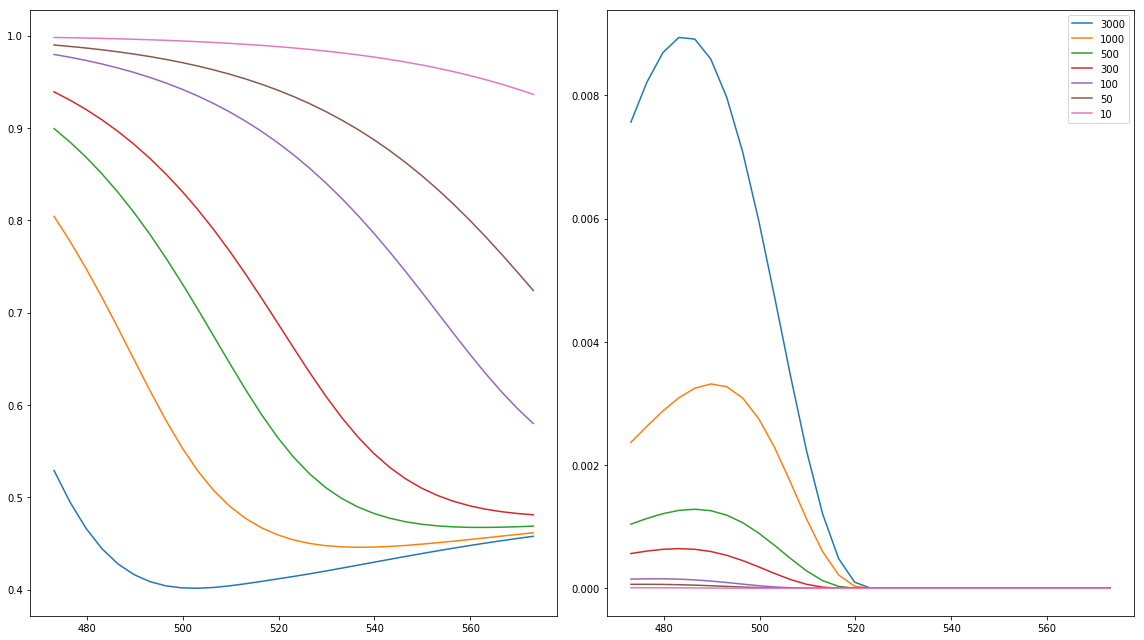

In [54]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])



for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
    
ax2.legend(catrange)

plt.tight_layout()
plt.show()

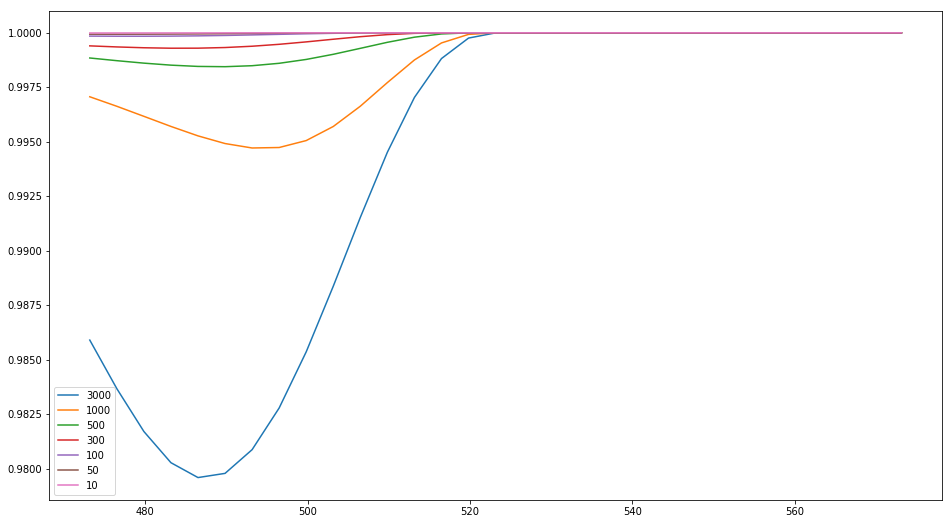

In [53]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))

ax1.legend(catrange)
plt.show()

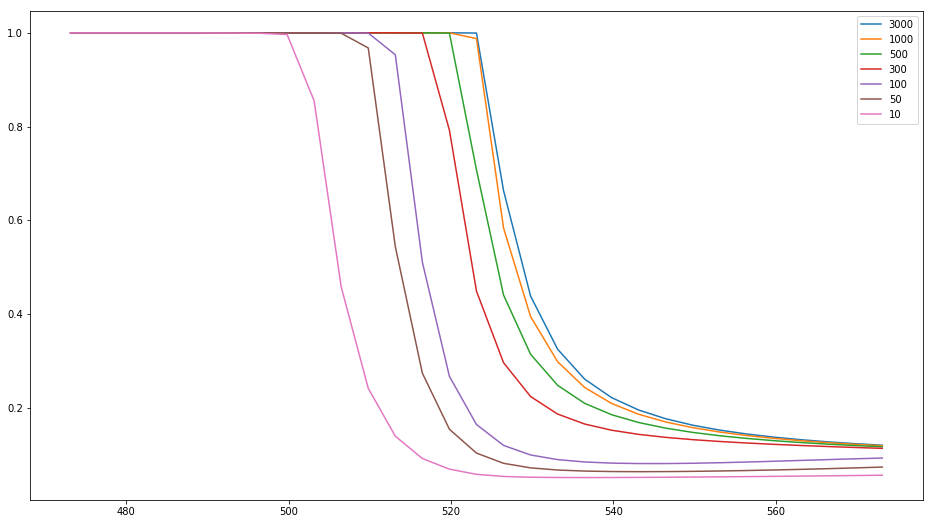

In [56]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['beta'])

ax1.legend(catrange)
plt.show()

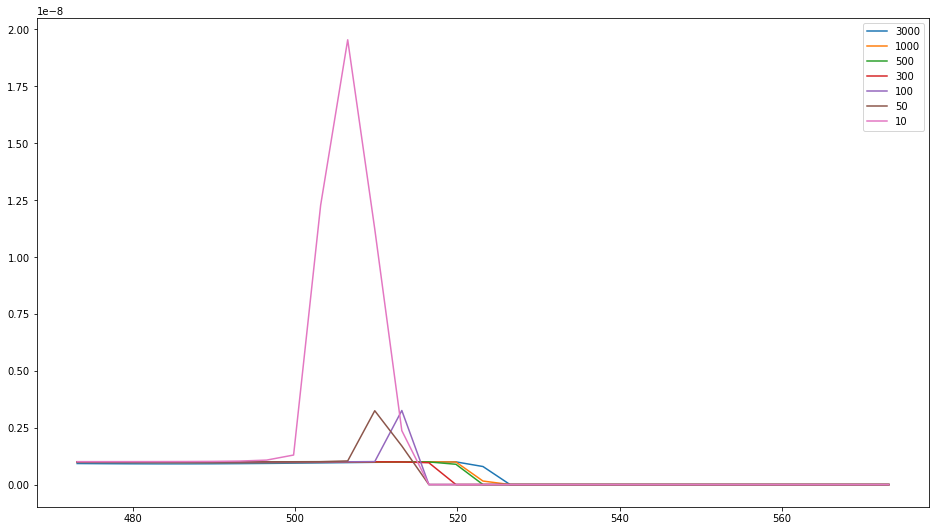

In [62]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))

ax1.legend(catrange)
plt.show()